In [245]:
import os

import keras.optimizers
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
from tensorflow.python.layers.core import flatten, dropout
from torch.ao.nn.quantized import Dropout

CSV_PATH = r"NeoJaundice\chd_jaundice_published_2.csv"
IMG_DIR = r"NeoJaundice\images"
df = pd.read_csv(CSV_PATH)

print("Dataset preview:")
print(df.head())

print("\nMissing values in each column:")
print(df.isnull().sum())

Dataset preview:
   patient_id   image_idx gender  gestational_age  age(day)  weight  \
0           3  0003-1.jpg      F               40       5.2    3280   
1           3  0003-2.jpg      F               40       5.2    3280   
2           3  0003-3.jpg      F               40       5.2    3280   
3          35  0035-1.jpg      M               39       8.7    3760   
4          35  0035-2.jpg      M               39       8.7    3760   

   blood(mg/dL)  Treatment  
0           3.9          0  
1           3.9          0  
2           3.9          0  
3          12.2          0  
4          12.2          0  

Missing values in each column:
patient_id         0
image_idx          0
gender             0
gestational_age    0
age(day)           6
weight             0
blood(mg/dL)       0
Treatment          0
dtype: int64


In [3]:
image_data = []
labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row['image_idx'])  
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))  
        image_data.append(img)
        labels.append(row['blood(mg/dL)'])
image_data = np.array(image_data)
labels = np.array(labels)
print(f"\nLoaded {len(image_data)} images.")


Loaded 2235 images.


In [144]:
def apply_color_correction(image, clip_limit=2.0, tile_grid_size=(8, 8), gamma=1.0):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l_corrected = clahe.apply(l)
    if gamma != 1.0:
        l_corrected = np.power(l_corrected / 255.0, gamma) * 255.0
        l_corrected = l_corrected.astype(np.uint8)
    lab_corrected = cv2.merge((l_corrected, a, b))
    final_corrected = cv2.cvtColor(lab_corrected, cv2.COLOR_LAB2BGR)
    
    return final_corrected
corrected_images = np.array([apply_color_correction(img) for img in image_data])
print(f"Color correction applied to {len(corrected_images)} images.")

Color correction applied to 2235 images.


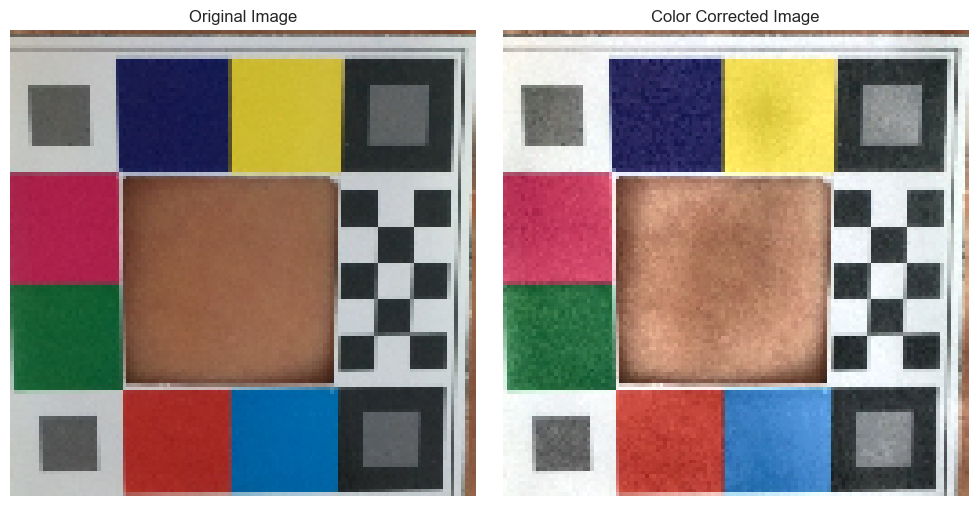

In [145]:
sample_idx = 146  # Any image index

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_data[sample_idx], cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(corrected_images[sample_idx], cv2.COLOR_BGR2RGB))
plt.title("Color Corrected Image")
plt.axis("off")
plt.tight_layout()
plt.show()

In [184]:
def crop_and_resize(image, central_fraction=0.4, target_size=(128, 128)):
    h, w = image.shape[:2]
    crop_h = int(h * central_fraction)
    crop_w = int(w * central_fraction)
    start_h = (h - crop_h) // 2
    start_w = (w - crop_w) // 2
    cropped = image[start_h:start_h + crop_h, start_w:start_w + crop_w]
    resized = cv2.resize(cropped, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
    return resized
def extract_skin_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 30, 60], dtype=np.uint8)
    upper = np.array([20, 150, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower, upper)
    skin = cv2.bitwise_and(image, image, mask=mask)
    return skin
segmented_images = []
for img in corrected_images:
    central_crop = crop_and_resize(img, central_fraction=0.40)
    segmented_images.append(central_crop)
segmented_images = np.array(segmented_images)
print(f"Segmented {len(segmented_images)} central skin regions.")


Segmented 2235 central skin regions.


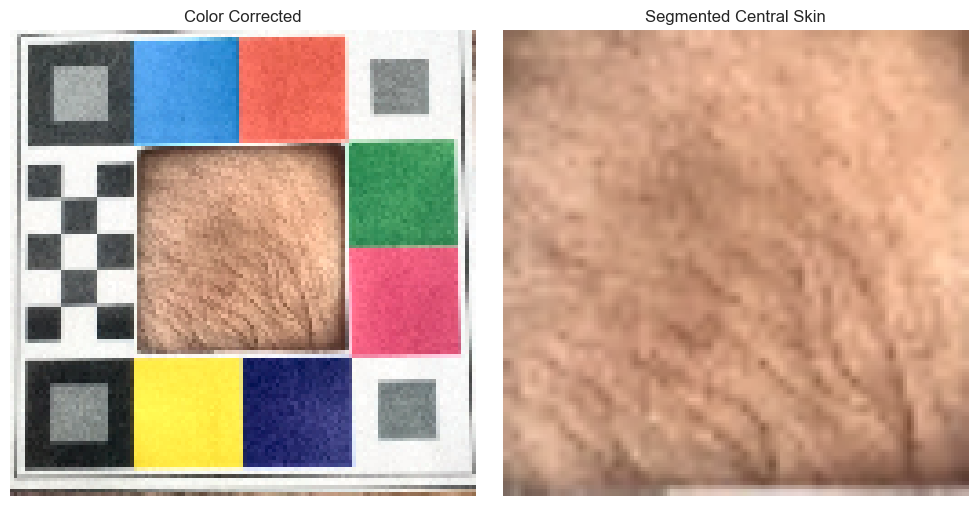

In [185]:
sample_idx = 531

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(corrected_images[sample_idx], cv2.COLOR_BGR2RGB))
plt.title("Color Corrected")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_images[sample_idx], cv2.COLOR_BGR2RGB))
plt.title("Segmented Central Skin")
plt.axis("off")
plt.tight_layout()
plt.show()

In [148]:
def convert_and_stack_all_spaces(images):
    combined = []
    for img in images:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Normalize all to [0, 1]
        img_rgb = img_rgb / 255.0
        img_hsv = img_hsv / 255.0
        img_lab = img_lab / 255.0

        # Stack all channels: shape becomes (128, 128, 9)
        stacked = np.concatenate([img_rgb, img_hsv, img_lab], axis=-1)
        combined.append(stacked)
    
    return np.array(combined)

In [149]:
combined_images = convert_and_stack_all_spaces(segmented_images)  
print("Combined shape:", segmented_images.shape)

Combined shape: (2235, 128, 128, 3)


In [186]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(segmented_images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [199]:
from keras.applications.mobilenet import MobileNet

In [242]:
conv_base = MobileNet(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

In [243]:
conv_base.trainable = False

for layer in conv_base.layers:
    print(layer.name,layer.trainable)

input_13 False
conv1 False
conv1_bn False
conv1_relu False
conv_dw_1 False
conv_dw_1_bn False
conv_dw_1_relu False
conv_pw_1 False
conv_pw_1_bn False
conv_pw_1_relu False
conv_pad_2 False
conv_dw_2 False
conv_dw_2_bn False
conv_dw_2_relu False
conv_pw_2 False
conv_pw_2_bn False
conv_pw_2_relu False
conv_dw_3 False
conv_dw_3_bn False
conv_dw_3_relu False
conv_pw_3 False
conv_pw_3_bn False
conv_pw_3_relu False
conv_pad_4 False
conv_dw_4 False
conv_dw_4_bn False
conv_dw_4_relu False
conv_pw_4 False
conv_pw_4_bn False
conv_pw_4_relu False
conv_dw_5 False
conv_dw_5_bn False
conv_dw_5_relu False
conv_pw_5 False
conv_pw_5_bn False
conv_pw_5_relu False
conv_pad_6 False
conv_dw_6 False
conv_dw_6_bn False
conv_dw_6_relu False
conv_pw_6 False
conv_pw_6_bn False
conv_pw_6_relu False
conv_dw_7 False
conv_dw_7_bn False
conv_dw_7_relu False
conv_pw_7 False
conv_pw_7_bn False
conv_pw_7_relu False
conv_dw_8 False
conv_dw_8_bn False
conv_dw_8_relu False
conv_pw_8 False
conv_pw_8_bn False
conv_pw_8_relu 

In [219]:
conv_base.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 64, 32) 

In [328]:
from keras.layers import Dropout
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Optional regularization
model.add(Dense(1, activation='relu'))  # Regression output

In [329]:
model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_53 (Flatten)        (None, 16384)             0         
                                                                 
 dense_100 (Dense)           (None, 64)                1048640   
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_101 (Dense)           (None, 1)                 65        
                                                                 
Total params: 4277569 (16.32 MB)
Trainable params: 1048705 (4.00 MB)
Non-trainable params: 3228864 (12.32 MB)
_________

In [330]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [331]:
import keras
model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mae'])

In [335]:
    history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25)

Epoch 1/25
49/49 [==============================] - 11s 211ms/step - loss: 32.1760 - mae: 4.6598 - val_loss: 23.3175 - val_mae: 4.0205
Epoch 2/25
49/49 [==============================] - 10s 211ms/step - loss: 23.2898 - mae: 3.9660 - val_loss: 21.5668 - val_mae: 3.8818
Epoch 3/25
49/49 [==============================] - 9s 182ms/step - loss: 21.8684 - mae: 3.8475 - val_loss: 20.7634 - val_mae: 3.8043
Epoch 4/25
49/49 [==============================] - 9s 192ms/step - loss: 20.3555 - mae: 3.7135 - val_loss: 20.4396 - val_mae: 3.7551
Epoch 5/25
49/49 [==============================] - 8s 157ms/step - loss: 19.3365 - mae: 3.5901 - val_loss: 20.4051 - val_mae: 3.7355
Epoch 6/25
49/49 [==============================] - 9s 184ms/step - loss: 18.3273 - mae: 3.5001 - val_loss: 19.7450 - val_mae: 3.6674
Epoch 7/25
49/49 [==============================] - 10s 211ms/step - loss: 18.6770 - mae: 3.5186 - val_loss: 19.9968 - val_mae: 3.6816
Epoch 8/25
49/49 [==============================] - 9s 188m

In [336]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test).flatten()
y_true = y_test.flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

11/11 [==============================] - 2s 129ms/step
MAE: 3.932
RMSE: 4.802
R² Score: 0.192
